In [7]:
from numpy import sqrt, cos, tan, sin, radians, degrees, pi, arctan2
import matplotlib.patches as mpatches
from scipy.optimize import fsolve
from scipy.integrate import quad
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp


In [11]:
g = 9.81
rim_width = 1.2192 #4ft
rim_height = 2.64
cargo_radius = 0.2413/2
drag_coeff = 0.23 #https://www.chiefdelphi.com/t/galactech-4926-build-blog-2022/398705/5
cargo_mass = 0.27
air_density = 1.225

cargo_area = pi * cargo_radius**2


def flight_model(t, s):
    x, vx, y, vy = s
    dx = vx
    dy = vy

    v_squared = vx**2 + vy**2
    v = sqrt(v_squared)

    sin_component = vy/v
    cos_component = vx/v

    Fd = 0.5 * air_density * cargo_area * drag_coeff * v_squared

    Fx = -Fd*cos_component
    Fy = -Fd*sin_component - cargo_mass*g

    # Fx = 0
    # Fy = - cargo_mass*g

    dvx = Fx / cargo_mass
    dvy = Fy / cargo_mass
    return [dx, dvx, dy, dvy]

def hit_ground(t, s):
    x, vx, y, vy = s
    return y
hit_ground.terminal = True

def hit_rim(t, s):
    x, vx, y, vy = s
    dist_to_rim = min(x - -rim_width/2, -(y - rim_height)) #positive if cargo is down and to the right of closest rim
    return dist_to_rim + cargo_radius
hit_rim.terminal = True

def passed_rim(t, s):
    x, vx, y, vy = s
    return x - rim_width/2
passed_rim.terminal = True

In [14]:
def try_shot(s0, doShow):
    t_span = (0, 5.0)
    solution = solve_ivp(flight_model, t_span, s0, events=[hit_ground, hit_rim, passed_rim], max_step=0.1)

    result = 0 #default is success
    if(solution.y[0][-1] < -rim_width/2):
        result = -1 #undershot
    elif(solution.y[0][-1] > rim_width/2 - cargo_radius):
        result = 1 #overshot

    if doShow:

        if result == -1: print("undershot")
        elif result == 0: print("success")
        elif result == 1: print("overshot")

        plt.plot(solution.y[0, :], solution.y[2, :], 'bo')

        left, bottom, width, height = (-rim_width/2, 0, rim_width, rim_height)
        rect=mpatches.Rectangle((left,bottom), width, height, fill=False, color="purple", linewidth=2)
        plt.gca().add_patch(rect)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.show()

        # print(solution)

    return result




undershot


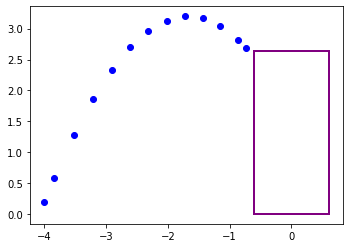

result: -1


In [15]:
#s0 is [xpos, xvel, ypos, yvel]
print("result:", try_shot(s0=[-4, 3.2, 0.2, 8], doShow=True))

In [16]:
from math import pi
x_range = np.arange(-6, -1, 0.1)
y_range = np.arange(0.2, 1.4, 0.1)

ang_range = np.linspace(radians(5), radians(85), num=10)
speed_range = np.linspace(10, 25, num=10)

everything = np.zeros((x_range.size, y_range.size, ang_range.size, speed_range.size))
print("everything shape", everything.shape)
print("everything cells", everything.size)

heatmap = np.zeros((x_range.size, y_range.size, 3))
vel_combos = ang_range.size * speed_range.size
print("vel combos", vel_combos)

everything shape (50, 12, 10, 10)
everything cells 60000
vel combos 100


In [6]:
from math import sin, cos

for xi in range(x_range.size):
    for yi in range(y_range.size):

        num_zeros = 0

        for angi in range(ang_range.size):
            for speedi in range(speed_range.size):

                vx = speed_range[speedi] * cos(ang_range[angi])
                vy = speed_range[speedi] * sin(ang_range[angi])

                cell = try_shot(s0=[x_range[xi], vx, y_range[yi], vy], doShow=False)
                everything[xi][yi][angi][speedi] = cell
                if cell == 0:
                    num_zeros += 1

        heatmap[xi, yi, 0] = num_zeros / vel_combos #overall probability of hitting target 


    print(f'x pos index {xi} of {x_range.size}')

print("done")

x pos index 0 of 50


KeyboardInterrupt: 

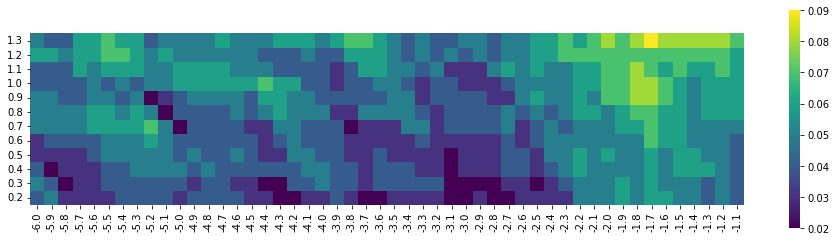

In [ ]:
import seaborn as sns

overall_prob = heatmap[:, :, 0]
overall_prob = np.swapaxes(overall_prob, 0, 1)

xlabels = np.round(x_range, 2)
ylabels = np.round(y_range, 2)

plt.figure(figsize = (16, 4))

ax = sns.heatmap(overall_prob, xticklabels=xlabels, yticklabels=ylabels, cmap='viridis', square=True)
ax.invert_yaxis()


# left, bottom, width, height = (-rim_width/2, 0, rim_width, rim_height)

# ax.add_patch(mpatches.Rectangle((left, bottom), width, height, edgecolor='red', fill=False, lw=1))


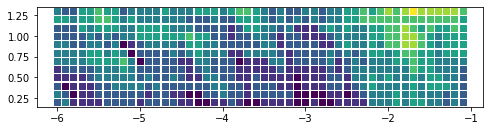

In [ ]:
plt.figure(figsize = (8, 8))
X, Y = np.meshgrid(xlabels, ylabels)
plt.scatter(X, Y, c=overall_prob, marker='s')
plt.gca().set_aspect('equal', adjustable='box')


overshot


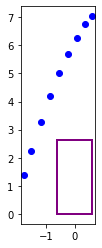

1

In [17]:
try_shot(s0=[-1.8, 3.5, 1.4, 12], doShow=1)

In [27]:
def refine_ang_speed_space(x, y, ang_range_dense, speed_range_dense):

    # ang_range_dense = np.linspace(min(ang_range), max(ang_range), ang_divs)
    # speed_range_dense = np.linspace(min(speed_range), max(speed_range), speed_divs)
    
    ang_speed_space = np.zeros((ang_range_dense.size, speed_range_dense.size))

    num_zeros = 0

    for angi in range(ang_range_dense.size):
        for speedi in range(speed_range_dense.size):

            vx = speed_range_dense[speedi] * cos(ang_range_dense[angi])
            vy = speed_range_dense[speedi] * sin(ang_range_dense[angi])

            cell = try_shot(s0=[x, vx, y, vy], doShow=False)

            if cell == 0: num_zeros += 1

            ang_speed_space[angi][speedi] = cell

    print("at x", x, "and y", y, "gets", num_zeros, "hits")
    # print(ang_speed_space)

    plt.figure(figsize = (8, 8))
    plt.title(f'shoot from x={x} and y={y}: area={num_zeros}')
    X, Y = np.meshgrid(ang_range_dense, speed_range_dense)
    plt.scatter(X, Y, c=ang_speed_space.T, marker='s')
    plt.xlabel("angle (radians)")
    plt.ylabel("speed (m/s)")
    plt.show()



at x -3.2 and y 0.5 gets 210 hits


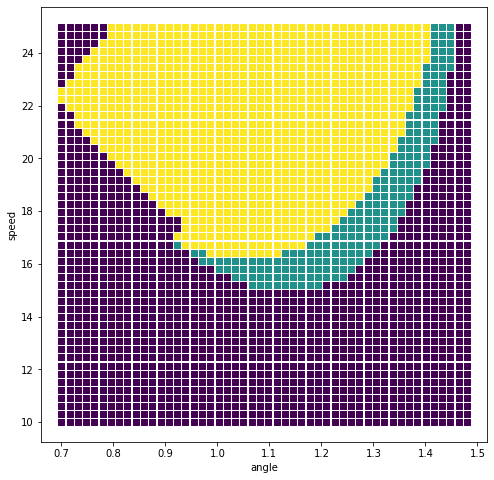

at x -2.2 and y 0.5 gets 207 hits


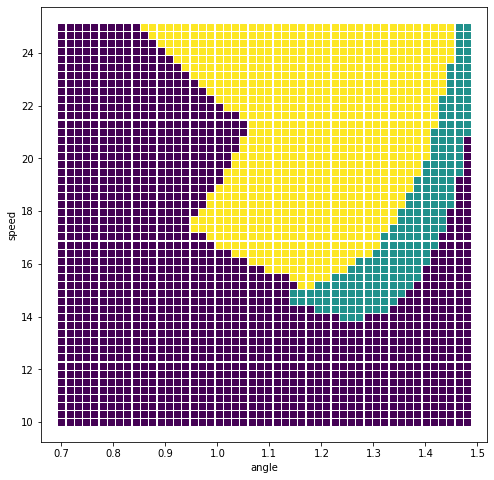

at x -1.2 and y 0.5 gets 104 hits


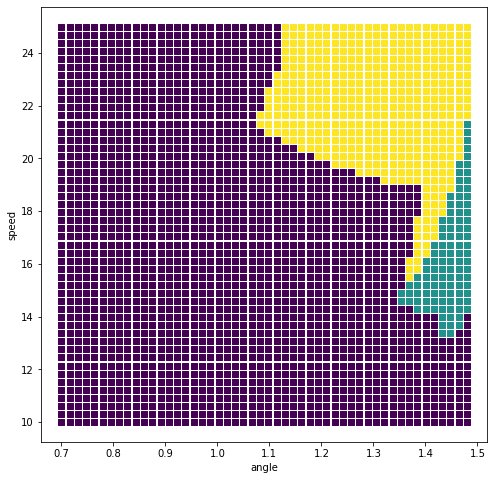

In [ ]:
refine_ang_speed_space(-3.2, 0.5, ang_range_dense=np.linspace(0.7, 1.48, 50), speed_range_dense=np.linspace(10, 25, 50))
refine_ang_speed_space(-2.2, 0.5, ang_range_dense=np.linspace(0.7, 1.48, 50), speed_range_dense=np.linspace(10, 25, 50))
refine_ang_speed_space(-1.2, 0.5, ang_range_dense=np.linspace(0.7, 1.48, 50), speed_range_dense=np.linspace(10, 25, 50))

at x -7.62 and y 0.9144 gets 544 hits


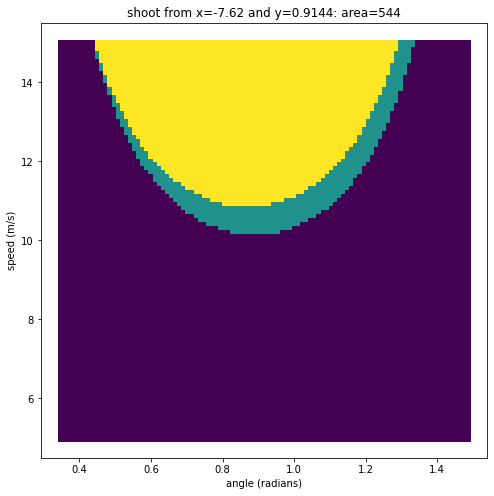

In [32]:
from math import radians
# refine_ang_speed_space(-2, 0.9144, ang_range_dense=np.linspace(radians(20), radians(85), 100), speed_range_dense=np.linspace(5, 15, 100))
# refine_ang_speed_space(-5, 0.9144, ang_range_dense=np.linspace(radians(20), radians(85), 100), speed_range_dense=np.linspace(5, 15, 100))
refine_ang_speed_space(-7.62, 0.9144, ang_range_dense=np.linspace(radians(20), radians(85), 100), speed_range_dense=np.linspace(5, 15, 100))

success


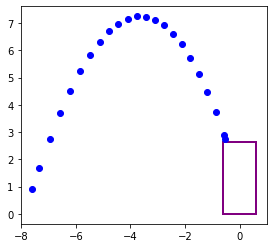

0

In [39]:
speed = 12.8
angle = 1.25
try_shot(s0=[-7.62, speed*cos(angle), 0.9144, speed*sin(angle)], doShow=True)

speed as a predicted function of angle matches simulation pretty well:
https://www.desmos.com/calculator/yjkeyjtnlf
![speed as a predicted function of angle matches simulation pretty well](desmos.png)
